In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, Lambda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

In [4]:
def custom_loss(y_true, y_pred):
    """Custom loss function that computes MSE between predicted and actual y values."""
    return tf.reduce_mean(tf.square(y_true - y_pred))

def train_and_evaluate_gru_model(target_variable, flag_train, _epochs=100, _batch_size=10):
    # Load your data from the Excel file
    mgh_data = pd.read_excel("gru-datasets.xlsx")

    # Select relevant features
    features = ['Timesteps [- / 5 minutes]', f'{target_variable} (Predicted GL)', f'{target_variable} (Predicted NN)']
    
    X = mgh_data[features]
    y = mgh_data[f'{target_variable} (Actual)']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape data for GRU input (samples, timesteps, features)
    X_train_q_physics = X_train_scaled[:, 1].reshape(-1, 1, 1)
    X_train_q_nn = X_train_scaled[:, 2].reshape(-1, 1, 1)
    X_test_q_physics = X_test_scaled[:, 1].reshape(-1, 1, 1)
    X_test_q_nn = X_test_scaled[:, 2].reshape(-1, 1, 1)

    if flag_train:
        # Define the input shapes
        time_steps = X_train_q_physics.shape[1]  # Should be 1 since we're using only one feature per time step

        # Inputs
        input_q_physics = Input(shape=(time_steps, 1), name='input_q_physics')
        input_q_nn = Input(shape=(time_steps, 1), name='input_q_nn')

        # Concatenate the features
        input_features = Concatenate()([input_q_physics, input_q_nn])

        # GRU Layer to process the time series data
        gru_output = GRU(units=64, return_sequences=False)(input_features)

        # Dense layers to predict w_physics and w_nn, using sigmoid to constrain them to [0, 1]
        w_physics = Dense(1, activation='sigmoid', name='w_physics')(gru_output)
        w_nn = Dense(1, activation='sigmoid', name='w_nn')(gru_output)

        # Calculate y_hat within the model
        q_physics = Lambda(lambda x: x[:, :, 0])(input_features)  # Extract q_physics
        q_nn = Lambda(lambda x: x[:, :, 1])(input_features)  # Extract q_nn

        # Compute y_hat
        y_hat = Lambda(lambda x: x[0] * x[1] + x[2] * x[3])([q_physics, w_physics, q_nn, w_nn])

        # Define the model
        model = Model(inputs=[input_q_physics, input_q_nn], outputs=y_hat)

        # Compile the model
        model.compile(optimizer='adam', loss=custom_loss, metrics=['mae', r2_score_metric])

        # Train the model
        history = model.fit([X_train_q_physics, X_train_q_nn], y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

        # Save the model and scaler
        model.save(f'gru-models/{target_variable}_model.keras')
        joblib.dump(scaler, f'gru-models/{target_variable}_gru_scaler.pkl')
    else:
        # Load the model and scaler
        model = load_model(f'gru-models/{target_variable}_model.keras', custom_objects={'custom_loss': custom_loss, 'r2_score_metric': r2_score_metric})
        scaler = joblib.load(f'gru-models/{target_variable}_gru_scaler.pkl')

        # Scale the test data
        X_test_scaled = scaler.transform(X_test)
        X_test_q_physics = X_test_scaled[:, 1].reshape(-1, 1, 1)
        X_test_q_nn = X_test_scaled[:, 2].reshape(-1, 1, 1)

    # Predict y_hat on test data
    y_hat_test = model.predict([X_test_q_physics, X_test_q_nn])

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)

    if flag_train:
        # Plot training history
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()

    # Plot of actual vs. predicted over time
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()


Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 514.0224 - mae: 22.6669 - r2_score_metric: -1286.0663 - val_loss: 501.7162 - val_mae: 22.3890 - val_r2_score_metric: -1220.8043
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 499.7906 - mae: 22.3422 - r2_score_metric: -1356.7445 - val_loss: 493.8342 - val_mae: 22.2094 - val_r2_score_metric: -1203.1296
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 492.3603 - mae: 22.1709 - r2_score_metric: -1124.0551 - val_loss: 491.3570 - val_mae: 22.1535 - val_r2_score_metric: -1196.9783
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 490.4586 - mae: 22.1282 - r2_score_metric: -1312.1726 - val_loss: 490.2726 - val_mae: 22.1293 - val_r2_score_metric: -1194.2063
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 488.9507 - mae: 22.0966 - r2_score_metric: -1318.0648 - val_loss: 489.6760 - val_mae: 22.1160 - val_r2_score_metric: -1192.6863
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

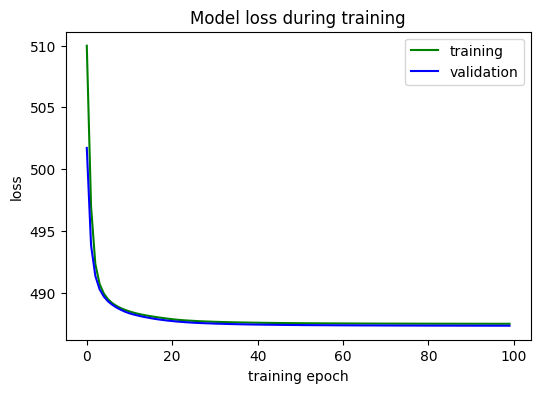

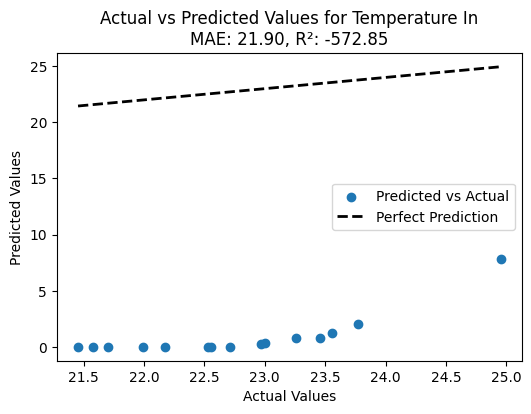

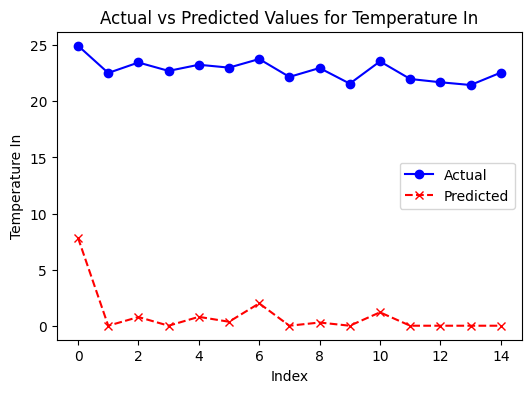

In [5]:
train_and_evaluate_gru_model(target_variable='Temperature In', flag_train=True, _epochs=100, _batch_size=10)